In [2]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm


import mediapipe as mp
import pandas as pd

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
#  dataset
class_names = ['Bulat', 'Lonjong', 'Oval']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (300, 300)

In [5]:
mp_face_mesh = mp.solutions.face_mesh

In [6]:
# Fungsi untuk mengekstraksi fitur wajah menggunakan face_mesh
def extract_face_features(image):
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)
    results = face_mesh.process(image)

    landmarks = results.multi_face_landmarks[0]

    face_oval = mp_face_mesh.FACEMESH_FACE_OVAL

    df = pd.DataFrame(list(face_oval), columns=["p1", "p2"])

    routes_idx = []

    p1 = df.iloc[0]["p1"]
    p2 = df.iloc[0]["p2"]

    for i in range(0, df.shape[0]):
        obj = df[df["p1"] == p2]
        p1 = obj["p1"].values[0]
        p2 = obj["p2"].values[0]

        current_route = []
        current_route.append(p1)
        current_route.append(p2)
        routes_idx.append(current_route)

    routes = []
    for source_idx, target_idx in routes_idx:
        source = landmarks.landmark[source_idx]
        target = landmarks.landmark[target_idx]

        relative_source = (int(source.x * image.shape[1]), int(source.y * image.shape[0]))
        relative_target = (int(target.x * image.shape[1]), int(target.y * image.shape[0]))

        routes.append(relative_source)
        routes.append(relative_target)

    mask = np.zeros((image.shape[0], image.shape[1]))
    mask = cv2.fillConvexPoly(mask, np.array(routes), 1)
    mask = mask.astype(bool)

    out = np.zeros_like(image)
    out[mask] = image[mask]

    return out


In [7]:
# from sklearn.model_selection import train_test_split

# # ... kode lainnya ...

# def load_data(test_size=0.2):
#     datasets = ['FaceData/training_set', 'FaceData/testing_set']
#     output = []

#     for dataset in datasets:
#         images = []
#         labels = []
#         print("Loading {}".format(dataset))
#         for folder in os.listdir(dataset):
#             if folder != "desktop.ini":
#                 label = class_names_label[folder]
#                 for file in tqdm(os.listdir(os.path.join(dataset, folder))):
#                     if file != "desktop.ini":
#                         img_path = os.path.join(os.path.join(dataset, folder), file)
#                         try:
#                             image = cv2.imread(img_path)
#                             image = extract_face_features(image)
#                             image = cv2.resize(image, IMAGE_SIZE)
#                             if image is not None:
#                                 images.append(image)
#                                 labels.append(label)
#                         except Exception as e:
#                             print(f"Broken: {img_path}")

#         images = np.array(images, dtype='float32')
#         labels = np.array(labels, dtype='int32')

#         output.append((images, labels))

#     # Split data menjadi data latih, data validasi, dan data uji menggunakan train_test_split
#     train_images, train_labels = output[0]
#     test_images, test_labels = output[1]
    
#     train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=test_size, random_state=42)
    
#     train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=test_size, random_state=42)
    
#     train_data = (train_images / 255.0, train_labels)
#     val_data = (val_images / 255.0, val_labels)
#     test_data = (test_images / 255.0, test_labels)

#     return train_data, val_data, test_data

In [8]:
# # Memuat data
# train_data, val_data, test_data = load_data(test_size=0.2)

In [9]:
# # Mendapatkan data latih, validasi, dan data uji serta labelnya
# train_images, train_labels = train_data
# val_images, val_labels = val_data
# test_images, test_labels = test_data

In [10]:
# # Membangun model
# model = Sequential([
#     Conv2D(60, (3, 3), activation='relu', input_shape=(300, 300, 3)),
#     MaxPooling2D(2, 2),
#     Conv2D(50, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
#     Dropout(0.2),
#     Conv2D(50, (3, 3), activation='relu', input_shape=(300, 300, 3)),
#     MaxPooling2D(2, 2),
#     Dropout(0.2),
#     Conv2D(40, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
#     Conv2D(30, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
#     Dropout(0.2),
#     Flatten(),
#     Dense(65, activation=tf.nn.softmax),
#     Dropout(0.2)
# ])

In [11]:
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
# # Pelatihan model
# history = model.fit(train_images, train_labels, batch_size=128, epochs=100, validation_data=(val_images, val_labels))


In [13]:
def load_data():
    datasets = ['FaceData/training_set', 'FaceData/testing_set']
    output = []

    for dataset in datasets:
        images = []
        labels = []
        print("Loading {}".format(dataset))
        for folder in os.listdir(dataset):
            if folder != "desktop.ini":
                label = class_names_label[folder]
                for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                    if file != "desktop.ini":
                        img_path = os.path.join(os.path.join(dataset, folder), file)
                        try:
                            image = cv2.imread(img_path)
                            image = extract_face_features(image)  # tambahkan ini jika diperlukan
                            image = cv2.resize(image, IMAGE_SIZE)  # ubah ukuran gambar ke ukuran yang seragam
                            if image is not None:
                                images.append(image)
                                labels.append(label)
                        except Exception as e:
                            print(f"Broken: {img_path}")

        images = np.array(images, dtype='float32')  # Ubah ke array NumPy
        labels = np.array(labels, dtype='int32')  # Ubah ke array NumPy

        output.append((images, labels))

    return output


In [14]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading FaceData/training_set


  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 26/26 [00:50<00:00,  1.95s/it]


Loading FaceData/testing_set


100%|██████████| 26/26 [00:25<00:00,  1.01it/s]


In [15]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [16]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

train_images = train_images / 255.0
test_images = test_images / 255.0

Number of training examples: 50
Number of testing examples: 50
Each image is of size: (300, 300)


In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(60, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(50, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(50, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(40, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(30, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(65, activation=tf.nn.softmax),
    tf.keras.layers.Dropout(0.2)
])

In [18]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [53]:
history = model.fit(train_images, train_labels, batch_size=12, epochs=50, validation_split = 0.2)

Epoch 1/50


4/4 [==============================] - 13s 3s/step - loss: 1.2633 - accuracy: 0.8000 - val_loss: 3.7289 - val_accuracy: 0.6000
Epoch 2/50
4/4 [==============================] - 10s 2s/step - loss: 2.3678 - accuracy: 0.7250 - val_loss: 3.3246 - val_accuracy: 0.6000
Epoch 3/50
4/4 [==============================] - 8s 2s/step - loss: 2.2725 - accuracy: 0.6500 - val_loss: 3.5609 - val_accuracy: 0.6000
Epoch 4/50
4/4 [==============================] - 8s 2s/step - loss: 1.2857 - accuracy: 0.8250 - val_loss: 4.0660 - val_accuracy: 0.5000
Epoch 5/50
4/4 [==============================] - 8s 2s/step - loss: 2.2685 - accuracy: 0.7250 - val_loss: 4.3633 - val_accuracy: 0.5000
Epoch 6/50
4/4 [==============================] - 8s 2s/step - loss: 1.9389 - accuracy: 0.7250 - val_loss: 4.6336 - val_accuracy: 0.5000
Epoch 7/50
4/4 [==============================] - 10s 3s/step - loss: 2.1947 - accuracy: 0.7000 - val_loss: 5.8439 - val_accuracy: 0.5000
Epoch 8/50
4/4 [==============================] -

In [54]:
# model.save("faceshape_model.h5")

In [55]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

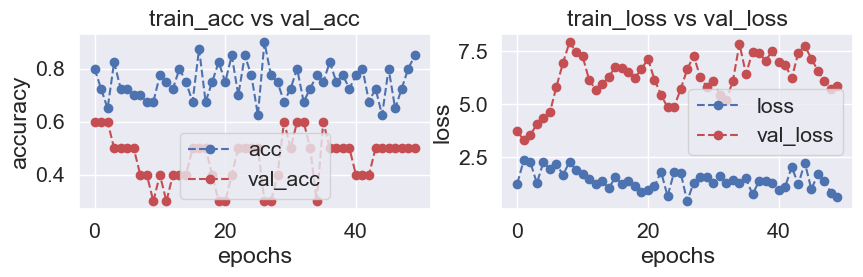

In [56]:
plot_accuracy_loss(history)

In [57]:
# Evaluasi model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')

2/2 [==============================] - 2s 812ms/step - loss: 1.1730 - accuracy: 0.9000
Test accuracy: 0.8999999761581421
Test loss: 1.1729693412780762


In [58]:
# test_loss = model.evaluate(test_images, test_labels)

In [59]:
def display_random_image(class_names, images, labels):
    """
    #Exibição de uma imagem aleatória
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

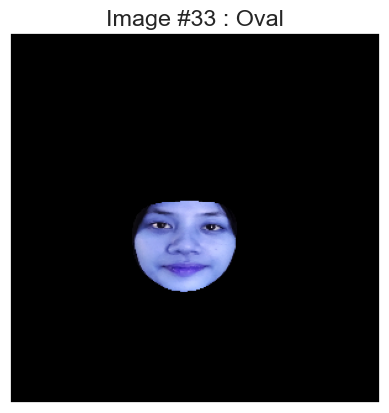

In [60]:
display_random_image(class_names, train_images, train_labels)

In [61]:
def display_examples(class_names, images, labels):
    """
    #Exibição de 25 imagens aleatórias e seus labels correspondentes
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

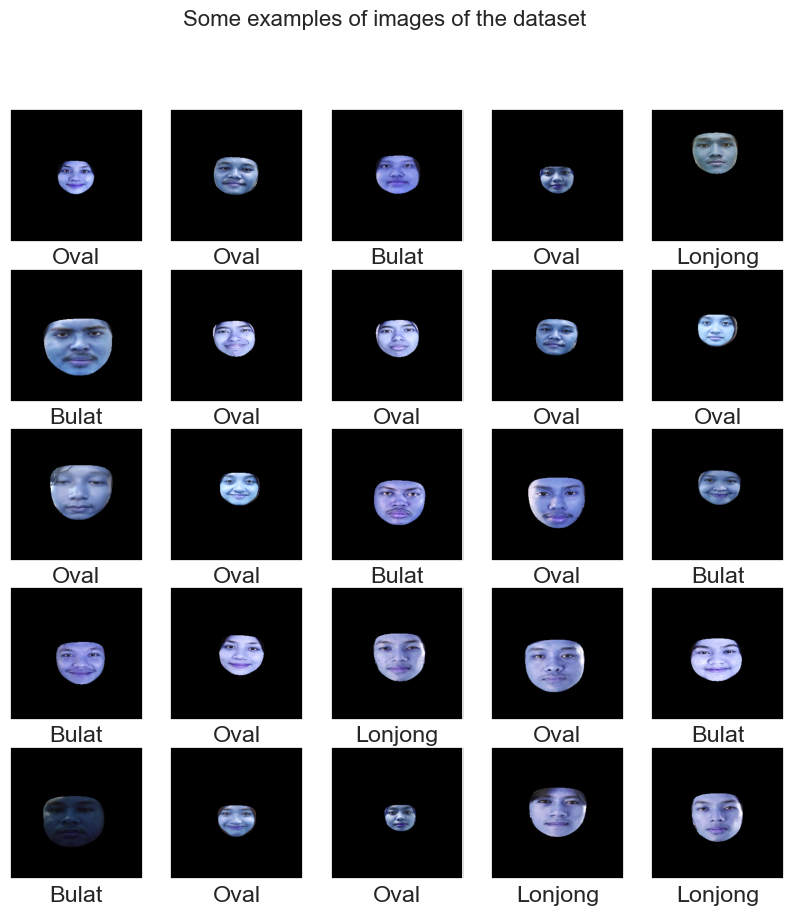

In [62]:
display_examples(class_names, train_images, train_labels)

2/2 [==============================] - 2s 1s/step


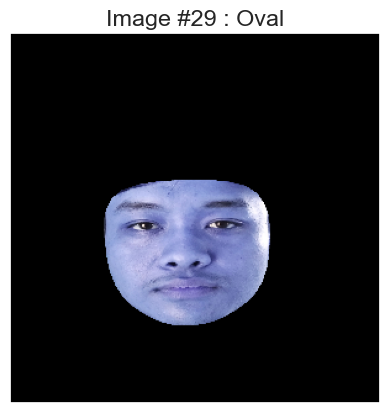

In [63]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

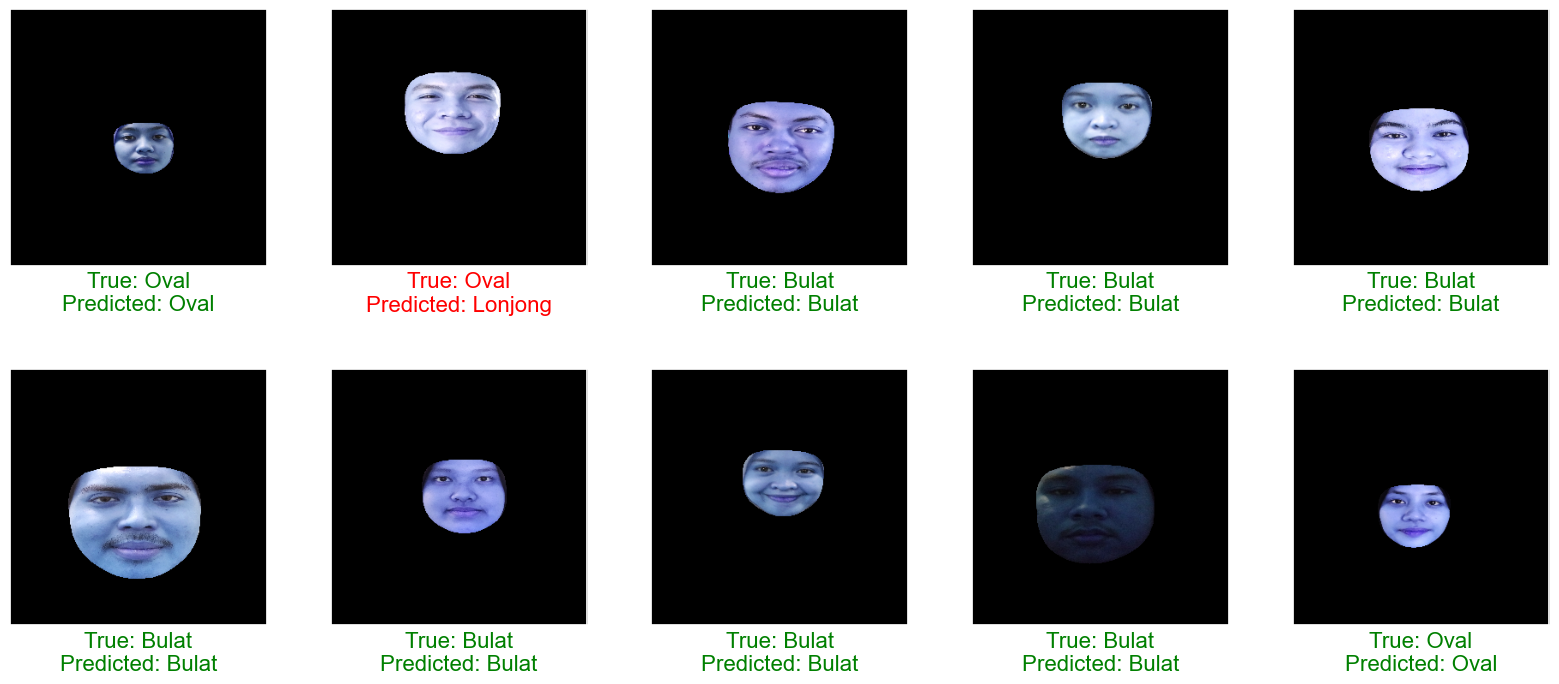

In [64]:
import random

def display_random_images(class_names, images, labels, predictions, num_examples=10):
    """
    Display 10 random images with their corresponding labels and predictions in a 2-row layout.
    """
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    plt.subplots_adjust(hspace=0.4)

    for i in range(num_examples):
        row = i // 5
        col = i % 5
        index = random.randint(0, len(images) - 1)
        axes[row, col].imshow(images[index], cmap=plt.cm.binary)
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])
        axes[row, col].grid(False)
        predicted_label = class_names[predictions[index]]
        true_label = class_names[labels[index]]
        if predicted_label == true_label:
            color = 'green'
        else:
            color = 'red'
        axes[row, col].set_xlabel(f"True: {true_label}\nPredicted: {predicted_label}", color=color, fontsize=16)
    plt.show()

# Display 10 random images with their corresponding labels and predictions
display_random_images(class_names, test_images, test_labels, pred_labels, num_examples=10)


In [65]:
# def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
#     """
#         Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
#     """
#     BOO = (test_labels == pred_labels)
#     mislabeled_indices = np.where(BOO == 0)
#     mislabeled_images = test_images[mislabeled_indices]
#     mislabeled_labels = pred_labels[mislabeled_indices]

#     title = "Some examples of mislabeled images by the classifier:"
#     display_examples(class_names, mislabeled_images, mislabeled_labels)

In [66]:
# print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

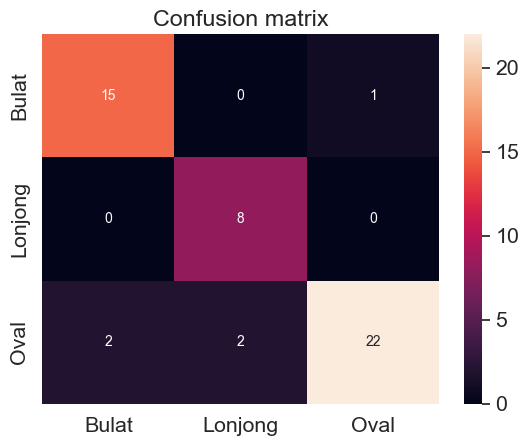

In [67]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [68]:
# Metrics 
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, pred_labels)
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, pred_labels)
# Recall
from sklearn.metrics import recall_score
recall_score(test_labels, pred_labels, average=None)
# Precision
from sklearn.metrics import precision_score
precision_score(test_labels, pred_labels, average=None)

#f1-score
from sklearn.metrics import f1_score
f1_score(test_labels, pred_labels, average=None)

#Classification Report
from sklearn.metrics import classification_report
print("Classification Report")
print(classification_report(test_labels, pred_labels, target_names=class_names))

Classification Report
              precision    recall  f1-score   support

       Bulat       0.88      0.94      0.91        16
     Lonjong       0.80      1.00      0.89         8
        Oval       0.96      0.85      0.90        26

    accuracy                           0.90        50
   macro avg       0.88      0.93      0.90        50
weighted avg       0.91      0.90      0.90        50



In [69]:
# model.save("faceshape.h5")